In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1


In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(5000):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

AttributeError: ignored

In [ ]:
env = gym.make('MsPacman-v0')
obs =env.reset()

In [ ]:
env.action_space

Discrete(9)

In [ ]:
mspacman_color = np.array([210,164,74]).mean()

In [ ]:

obs.shape

(210, 160, 3)

In [ ]:
env.render(mode="rgb_array")

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[228, 111, 111],
        [228, 111, 111],
        [228, 111, 111],
        ...,
        [228, 111, 111],
        [228, 111, 111],
        [228, 111, 111]],

       [[228, 111, 111],
        [228, 111, 111],
        [228, 111, 111],
        ...,
        [228, 111, 111],
        [228, 111, 111],
        [228, 111, 111]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]
    img = img.sum(axis=2)
    img[img==mspacman_color] = 0
    img = (img // 3 - 128).astype(np.int8)
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

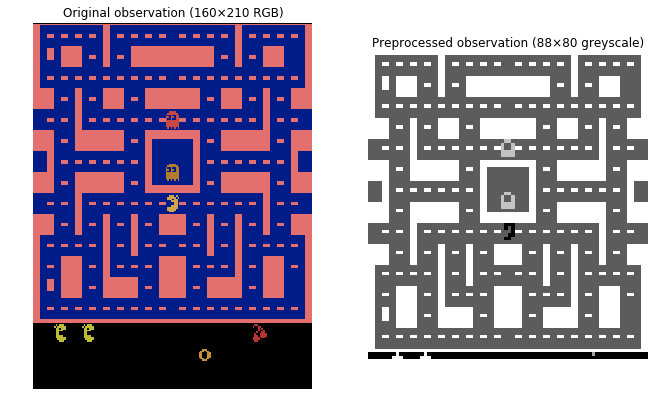

In [ ]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")

plt.show()

In [ ]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [ ]:
env.reset()
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left


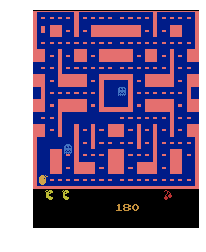

In [ ]:
plot_environment(env)

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)


In [ ]:
env.close()

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.contrib.layers import convolution2d,fully_connected

In [ ]:
tf.reset_default_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [ ]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)


W0716 11:54:05.434115 139621314545536 deprecation.py:323] From <ipython-input-22-4b23727a57e4>:26: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0716 11:54:05.764470 139621314545536 deprecation.py:323] From <ipython-input-22-4b23727a57e4>:30: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [ ]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [ ]:

learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

W0716 11:54:14.596690 139621314545536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:

class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) 
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]
        



In [ ]:
replay_memory_size = 50
replay_memory = ReplayMemory(replay_memory_size)

In [ ]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [ ]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return np.argmax(q_values) 

In [ ]:
n_steps = 4000  
training_start = 10000  
training_interval = 4 
save_steps = 1000  
copy_steps = 10000   
discount_rate = 0.99
skip_start = 90  
batch_size = 50
iteration = 0 
checkpoint_path = "./my_dqn.ckpt"
done = True 

In [ ]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [ ]:
import os
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: 
            obs = env.reset()
            for skip in range(skip_start): 
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue 
        
        
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        
        if step % copy_steps == 0:
            copy_online_to_target.run()

        
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)


W0716 11:56:05.281105 139621314545536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Iteration 25992	Training step 3999/4000 (100.0)%	Loss 1.144343	Mean Max-Q 0.310848   

KeyboardInterrupt: ignored

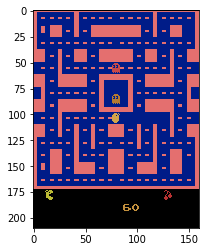

In [ ]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        plt.imshow(img)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            break
    ipythondisplay.clear_output(wait=True)
env.close()

In [ ]:
0000000000000000000000000000000000000000000000000000000000000000000000